In [1]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder,PolynomialFeatures,MinMaxScaler,label_binarize
from sklearn import neighbors,metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score,plot_roc_curve,roc_curve,f1_score
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.model_selection import cross_val_score

import math
import os,sys
from scipy.io import arff
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib import rcParams
import statsmodels.api as sm
import re
import scikitplot as skplt
from IPython.display import Image

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

fixedrstate = 0
sns.set_style('white')
rcParams['figure.figsize'] = 11.7,8.27

import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## (a) Retrieve Data

In [2]:
# Get all the filenames and remove pdfs and .DSStore
all_files = []
for root, dirs, files in os.walk("../data/AReM/", topdown=False):
    for name in files:
        all_files.append(os.path.join(root, name))
all_files
pdfs = [files for files in all_files if '.pdf' in files]
dsstore = [files for files in all_files if '.DS' in files]
for i in pdfs:
    all_files.remove(i)
for i in dsstore:
    all_files.remove(i)
print(len(all_files))
#all_files

88


In [3]:
#sort the files and fix the numeric ordering based on str to int
all_files.sort(key=lambda x: (x.split('/')[-2],int(re.search('\d+',x.split('/')[-1])[0])) )
#all_files

In [4]:
# TEST FLATTENING
#dataset= pd.read_csv(all_files[0],skiprows=4,usecols=range(1,7))
#x= dataset.describe().transpose()[['min','max','mean','50%','std','25%','75%']]
#y =x.to_numpy().reshape(1,42) # flatten this frame and put it into the master for all 88 files - to_numpy() is recommended according to pandas
#y.shape


## (b) Segregation in Train and Test

In [5]:
#decide test or train
all_files
test_files = ['bending1/dataset1.csv','bending1/dataset2.csv',
              'bending2/dataset1.csv','bending2/dataset2.csv',
              'cycling/dataset1.csv','cycling/dataset2.csv','cycling/dataset3.csv',
              'lying/dataset1.csv','lying/dataset2.csv','lying/dataset3.csv',
              'sitting/dataset1.csv','sitting/dataset2.csv','sitting/dataset3.csv',
              'standing/dataset1.csv','standing/dataset2.csv','standing/dataset3.csv',
              'walking/dataset1.csv','walking/dataset2.csv','walking/dataset3.csv',
             ]

for i,c in enumerate(test_files):
    test_files[i] = '../data/AReM/'+test_files[i]
#test_files

## (C) Features Extraction

### (i) Typical time domain features usually used in time series classification are maximum, mean, polar difference, variance, peak trough, kurtosis, etc.

In [6]:
def get_complete_data(all_files):
    master=pd.DataFrame([])
    for filename in all_files:
        dataset = pd.read_csv(filename,skiprows=4,usecols=range(1,7))
        temp = dataset.describe().transpose()[['min','max','mean','50%','std','25%','75%']].to_numpy().reshape((1,42))
        temp = pd.DataFrame(temp)
        temp['activity'] = re.sub('\d+','',filename.split('/')[-2])
        if filename in test_files:
            temp['test_train'] = 'test'
        else:
            temp['test_train'] = 'train'
        master = master.append(temp,ignore_index=True)
    return master

In [7]:
cols=pd.DataFrame([])
for i in range(1,7):
    temp = pd.DataFrame(['min'+str(i),'max'+str(i),'mean'+str(i),'median'+str(i),'stddev'+str(i),'1stQuart'+str(i),'3rdQuart'+str(i)])
    cols = cols.append(temp)
cols =cols.to_numpy().flatten()
cols = np.append(cols,'activity')
cols = np.append(cols,'test_train')

In [8]:
complete_data = get_complete_data(all_files)
complete_data.columns= cols
complete_data

,min1,max1,mean1,median1,stddev1,1stQuart1,3rdQuart1,min2,max2,mean2,...,3rdQuart5,min6,max6,mean6,median6,stddev6,1stQuart6,3rdQuart6,activity,test_train
0,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000,bending,test
1,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372437,...,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000,bending,test
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,bending,train
3,33.00,47.75,42.179812,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,bending,train
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,bending,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,walking,train
84,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,17.75,0.00,9.67,3.432563,3.20,1.732727,2.1575,4.5650,walking,train
85,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,walking,train
86,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,walking,train


In [9]:
Train_data = complete_data.loc[complete_data['test_train']=='train',complete_data.columns[:-1]]
Test_data = complete_data.loc[complete_data['test_train']=='test',complete_data.columns[:-1]]

print('Test Data Size is:',Test_data.shape[0])
print('Train Data Size is:',Train_data.shape[0])

Test Data Size is: 19
Train Data Size is: 69


In [10]:
#from sklearn.preprocessing import Normalizer
#transformer = Normalizer().fit(complete_data.loc[:,complete_data.columns[:-1]] )
#normalized_df = pd.DataFrame(transformer.transform(complete_data.loc[:,complete_data.columns[:-1]]),columns = cols[:-1])
#normalized_df

complete_data

,min1,max1,mean1,median1,stddev1,1stQuart1,3rdQuart1,min2,max2,mean2,...,3rdQuart5,min6,max6,mean6,median6,stddev6,1stQuart6,3rdQuart6,activity,test_train
0,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000,bending,test
1,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372437,...,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000,bending,test
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,bending,train
3,33.00,47.75,42.179812,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,bending,train
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,bending,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,walking,train
84,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,17.75,0.00,9.67,3.432563,3.20,1.732727,2.1575,4.5650,walking,train
85,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,walking,train
86,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,walking,train


## (c) iii. Estimate Std Dev and 90% Confidence Intervals
(for std dev of each feature)

In [11]:
est_feature_stddev = pd.DataFrame(complete_data.describe().transpose()['std'])
est_feature_stddev

,std
min1,9.569975
max1,4.394362
mean1,5.335718
median1,5.440054
stddev1,1.772153
1stQuart1,6.153590
3rdQuart1,5.138925
min2,0.000000
max2,5.062729
mean2,1.574164


In [12]:
res= []#pd.DataFrame([],index=cols[:-1],columns = ['value','lower_bound','upper_bound'])
for i in complete_data.columns[:-2]:
    stdev_results = bs.bootstrap(complete_data[i].to_numpy() , stat_func=bs_stats.std,alpha=0.1)
    res.append({'value':stdev_results.value,'90%_CI_lower_bound':stdev_results.lower_bound,'90%_CI_upper_bound':stdev_results.upper_bound})

#res= pd.DataFrame(res,index =cols[:-1],columns=['std'])
res= pd.DataFrame(res)#,index=cols[:-1],columns = ['value','lower_bound','upper_bound'])
res.index=cols[:-2]
res

,value,90%_CI_lower_bound,90%_CI_upper_bound
min1,9.515445,8.281921,10.812295
max1,4.369322,3.477981,5.447330
mean1,5.305314,4.762754,5.939121
median1,5.409056,4.853923,6.048558
stddev1,1.762056,1.582925,1.961260
1stQuart1,6.118526,5.638229,6.701429
3rdQuart1,5.109643,4.417727,5.904893
min2,0.000000,0.000000,0.000000
max2,5.033882,4.685015,5.468077
mean2,1.565194,1.432262,1.746128


## (c) iv. Feature selections

Selected features : **mean, max, 3rdQuart**
* Reason for selection of above features : The 90% percent confidence interval for above parameters is consistently narrow amongst all the features which intuitively indicates a robustness of the features.

# (d) Binary Classification Using Logistic Regression

## (d) i. Scatter plots of selected features
(and activities - Bending vs Other)

In [13]:
def bending_notbending(x):
    if x=='bending':
        return x
    return 'other'

In [14]:
bin_class_df = Train_data[['mean1','max1','3rdQuart1','mean2','max2','3rdQuart2','mean6','max6','3rdQuart6','activity']]#.loc[Train_data['activity']=='bending',:].shape
bin_class_df['activity'] = bin_class_df['activity'].apply(lambda x:bending_notbending(x))

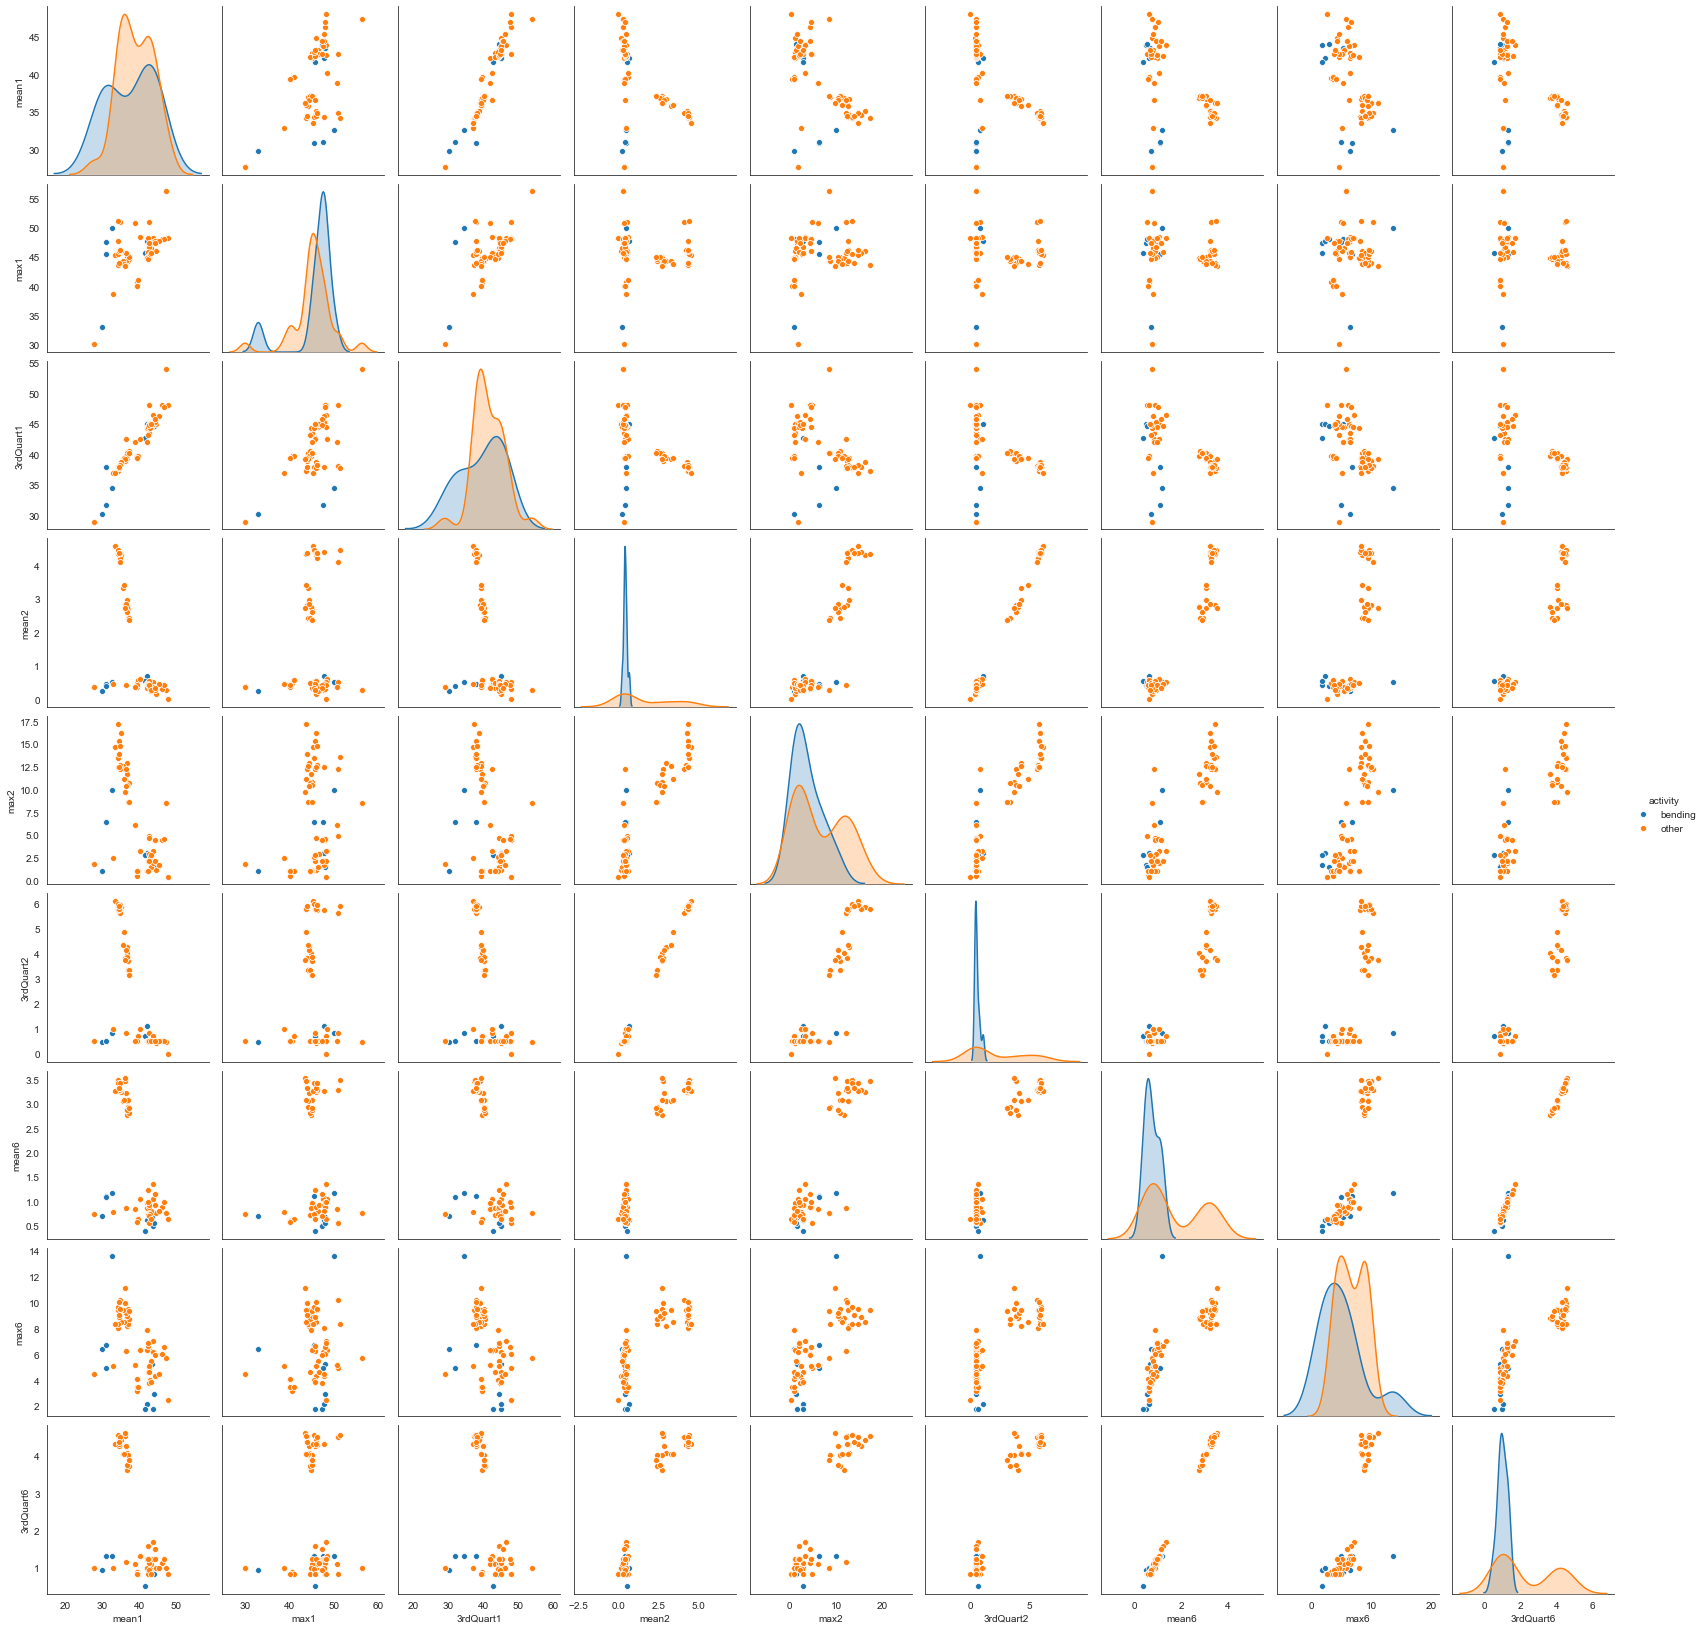

In [15]:
sns.pairplot(bin_class_df,hue = 'activity',kind='scatter')
plt.show()

In [16]:
bin_class_df.shape

(69, 10)

## (d) ii. Breaking Time Series in 2 parts 

In [17]:
def get_complete_data_2(all_files,num_slices):
    master=pd.DataFrame([])
    for filename in all_files:
        dataset = pd.read_csv(filename,skiprows=4,usecols=range(1,7))
        size = math.ceil(dataset.shape[0]/num_slices) #get halfrows
        #print(size)
        slices = []
        temp =None
        for i in range(0,dataset.shape[0],size):
            one_slice = dataset.loc[i:i+size,:]
            slices.append(one_slice)
            #print(one_slice)
        
        row = np.array([])
        for a_slice in slices:
            #['min','max','mean','50%','std','25%','75%']
            temp = a_slice.describe().transpose()[['max','mean','75%']].values.flatten()#.to_numpy().reshape((1,42))
            row = np.append(row,temp)
        temp = pd.DataFrame(row.reshape(1,3*6*num_slices)) 
        

        temp['activity'] = re.sub('\d+','',filename.split('/')[-2])
        if filename in test_files:
            temp['test_train'] = 'test'
        else:
            temp['test_train'] = 'train'
        master = master.append(temp,ignore_index=True)
        
    cols=pd.DataFrame([])
    for i in range(1,(6*num_slices)+1):
        temp = pd.DataFrame(['max'+str(i),'mean'+str(i),'3rdQuart'+str(i)])
        cols = cols.append(temp)
    cols =cols.to_numpy().flatten()
    cols = np.append(cols,'activity')
    cols = np.append(cols,'test_train')
    #print(cols)
    master.columns = cols
        
    return master

In [18]:
twelve_ts_df = get_complete_data_2(all_files,2)
#twelve_ts_df

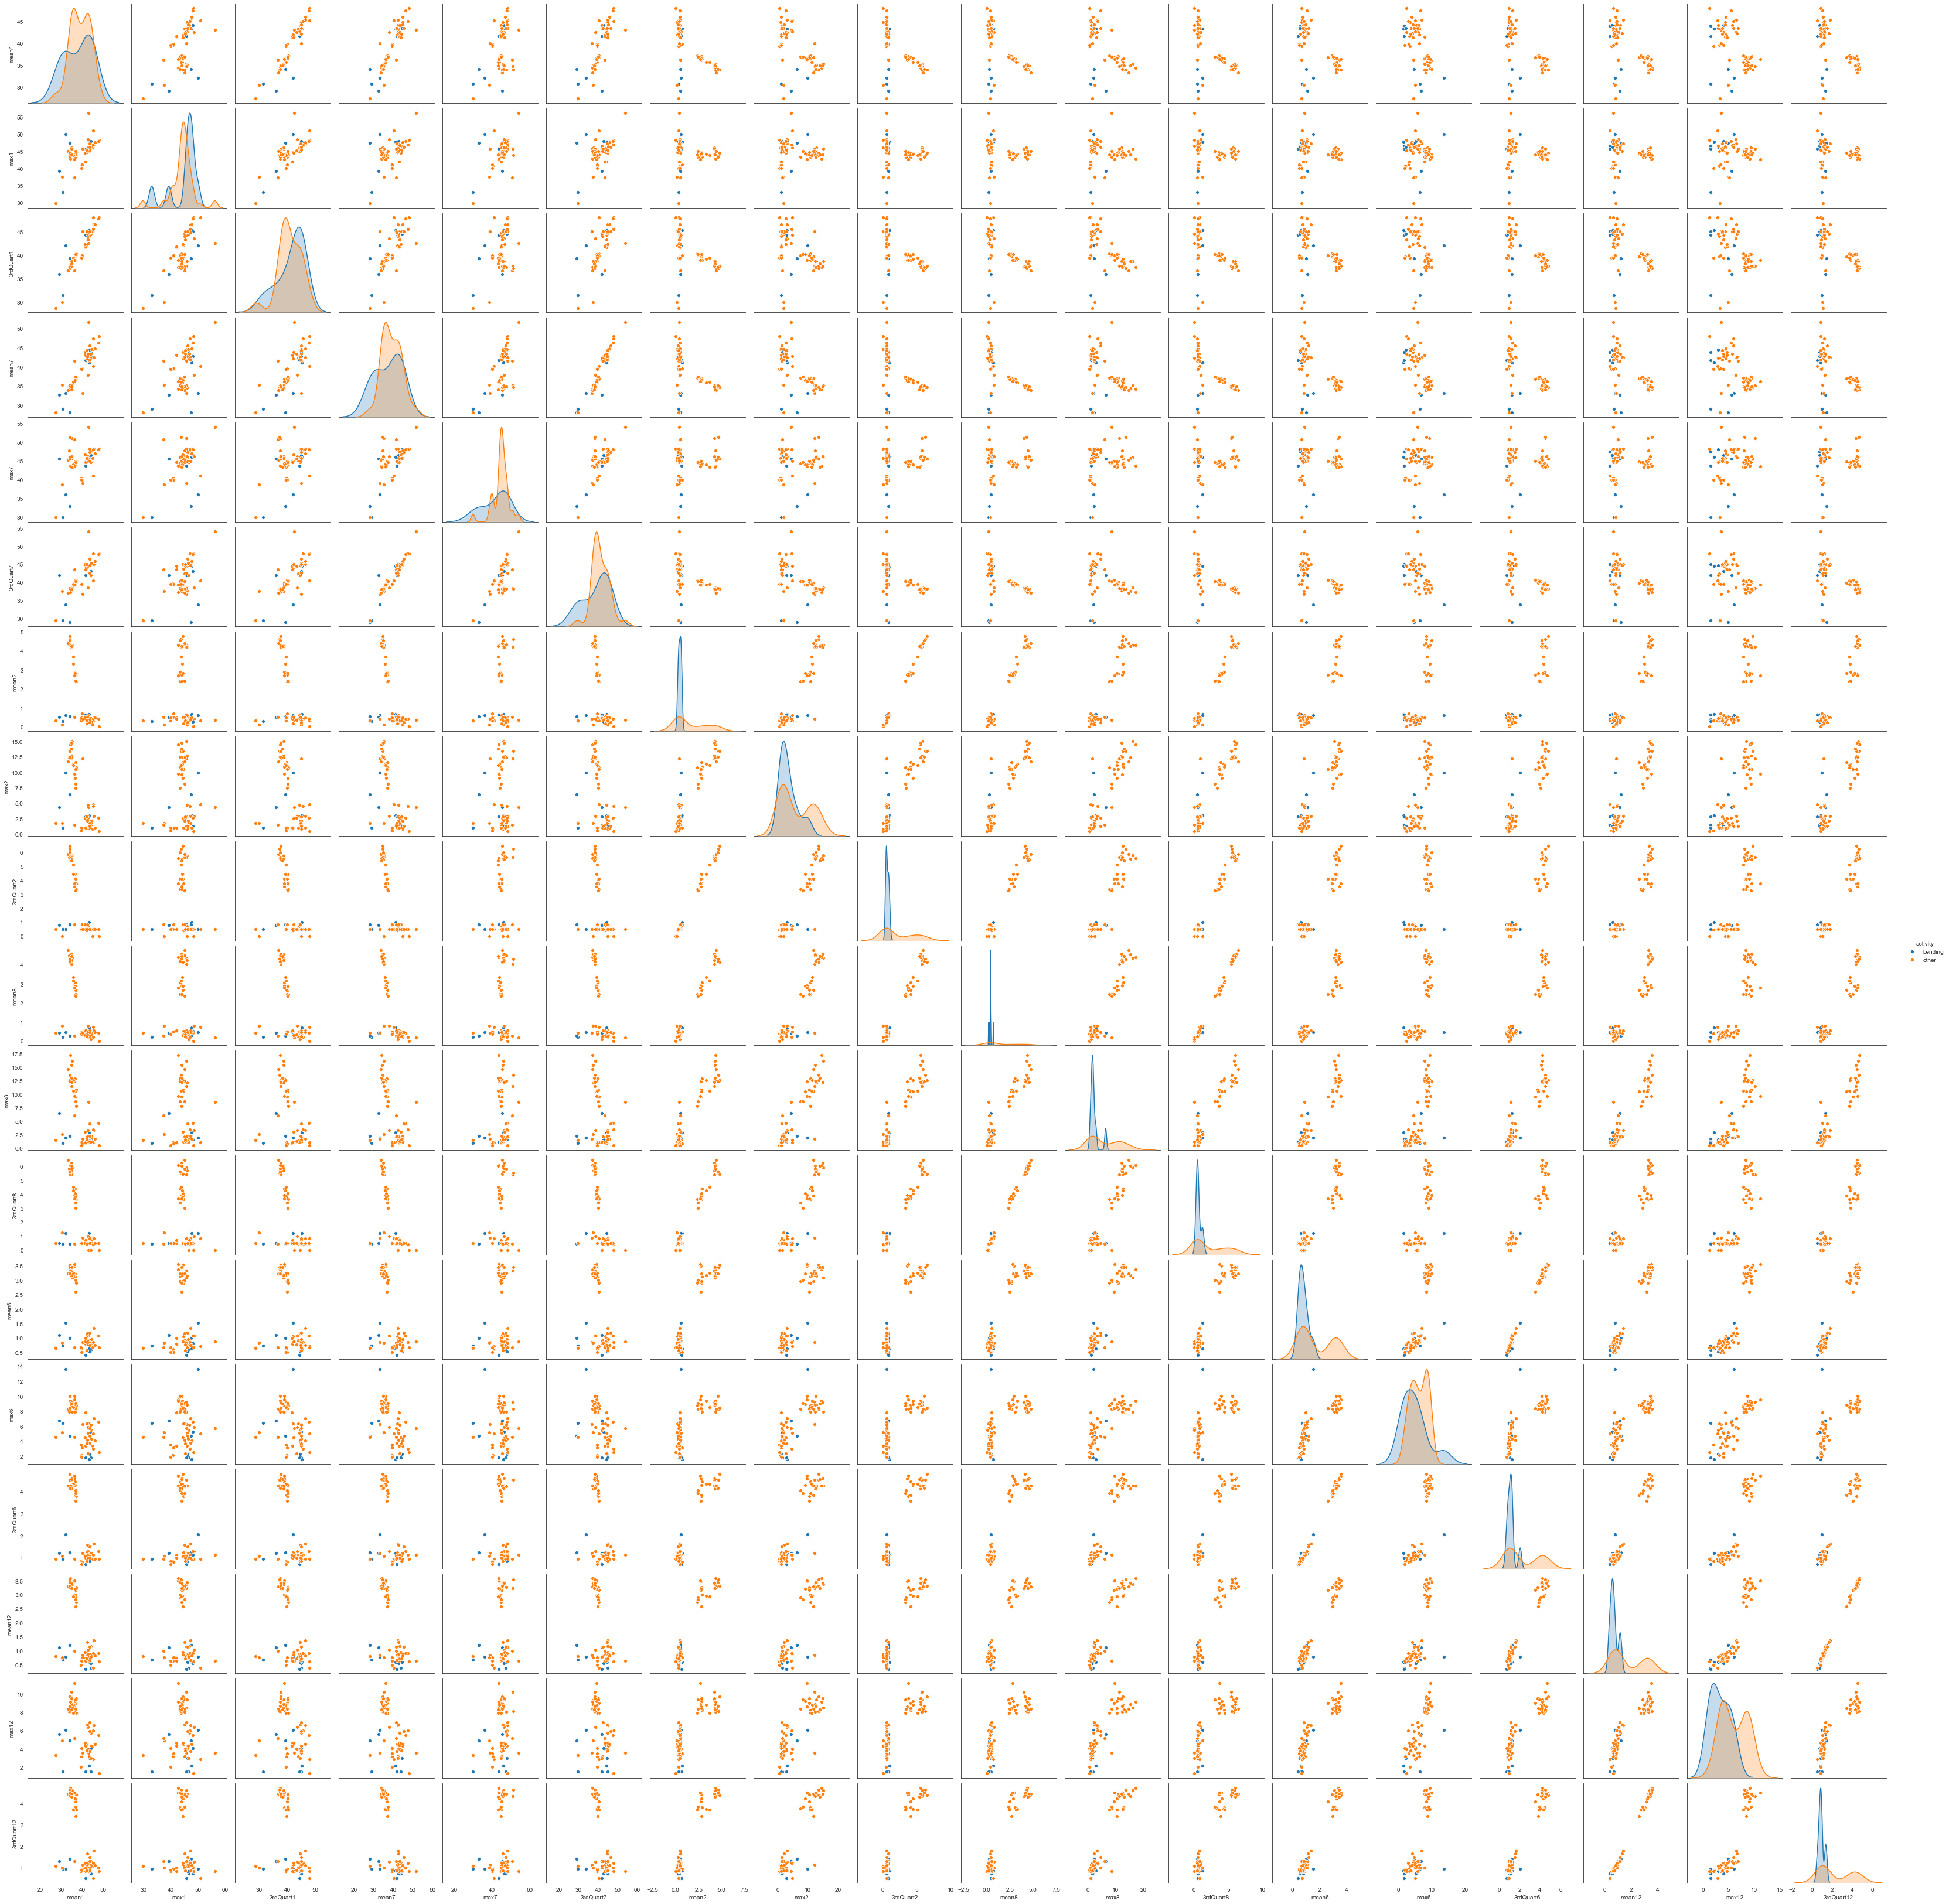

In [19]:
train_data_new = twelve_ts_df.loc[twelve_ts_df['test_train']=='train',:]
new_class_df = train_data_new[['mean1','max1','3rdQuart1','mean7','max7','3rdQuart7','mean2','max2','3rdQuart2','mean8','max8','3rdQuart8','mean6','max6','3rdQuart6','mean12','max12','3rdQuart12','activity']]#.loc[Train_data['activity']=='bending',:].shape
new_class_df['activity'] = new_class_df['activity'].apply(lambda x:bending_notbending(x))
sns.pairplot(new_class_df,hue = 'activity',kind='scatter')
plt.show()

There seems to be similar clustering of points in both the plots shown above.

Note:
The 1st time series is split into the feature indices of 1 and 7
similarly the 2nd time series is split into the indices of 2 and 8
and the 6th time series is split into the indices of 6 and 12

## (d) iii. Logistic Regression (Binary Classification)

In [20]:
def label_encode(x):
    if x=='bending':
        return 1
    return 0

In [21]:

res_dict = []
for l in range(1,21):
    X = get_complete_data_2(all_files,l)
    # Train
    X_train = X.loc[X['test_train']=='train',:]
    X_train['activity'] = X_train['activity'].apply(lambda x:label_encode(x))
    y_train = X_train['activity']
    X_train = X_train.drop(['activity','test_train'],axis=1)

    # Test
    #X_test = X.loc[X['test_train']=='test',:]
    #X_test['activity'] = X_test['activity'].apply(lambda x:label_encode(x))
    #y_test = X_test['activity']
    #X_test = X_test.drop(['activity','test_train'],axis=1)

    logreg_clf = LogisticRegression(C=sys.maxsize)#(cv=cv, random_state=0,n_jobs=-1).fit(X_train, y_train)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=fixedrstate)
    rfecv = RFECV(logreg_clf,cv=cv,n_jobs = -1)
    rfecv.fit(X_train,y_train)
    #clf = LogisticRegression(cv=cv, random_state=0,n_jobs=-1).fit(X_train, y_train)
    
    #score= clf.score(X_test,y_test)
    res_dict.append({'l':l,'rfe_support':rfecv.support_,'rfe_ranking':rfecv.ranking_,'best_grid_score':rfecv.grid_scores_[rfecv.n_features_-1],'num_features':rfecv.n_features_})
res_dict = pd.DataFrame(res_dict)
res_dict


,l,rfe_support,rfe_ranking,best_grid_score,num_features
0,1,"[False, False, True, False, False, False, Fals...","[8, 3, 1, 5, 13, 6, 12, 4, 1, 14, 11, 10, 1, 1...",0.985165,5
1,2,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 5, 1, 1, 1, ...",0.963736,31
2,3,"[True, False, False, False, False, False, Fals...","[1, 20, 38, 12, 48, 30, 34, 1, 9, 35, 36, 31, ...",0.984615,7
3,4,"[False, False, False, False, False, False, Fal...","[10, 32, 59, 22, 57, 58, 40, 8, 21, 16, 67, 66...",0.978571,4
4,5,"[False, False, False, False, False, False, Fal...","[60, 45, 38, 62, 71, 73, 44, 12, 29, 82, 84, 6...",0.978571,5
5,6,"[False, False, False, False, False, False, Fal...","[66, 54, 38, 37, 86, 73, 97, 21, 70, 100, 92, ...",0.970879,4
6,7,"[False, False, False, False, False, False, Fal...","[112, 97, 49, 45, 92, 56, 108, 29, 86, 100, 10...",0.978022,12
7,8,"[False, False, False, False, False, False, Fal...","[126, 78, 45, 47, 90, 59, 105, 16, 95, 103, 12...",0.978022,16
8,9,"[False, False, False, False, False, False, Fal...","[117, 103, 65, 64, 136, 95, 116, 37, 84, 113, ...",0.971429,9
9,10,"[False, False, False, False, False, False, Fal...","[161, 99, 121, 145, 157, 143, 92, 1, 51, 84, 1...",0.963736,17


### Right way and Wrong way of Cross Validation:
* The right way of cross validation is including feature selection as part of the cross validation procedure since this is a type of training where the model is exposed to training data and hence must be included in Cross Validation which means we need to find (l,p) simultaneously 
* The wrong way of cross validation would be to select a set of features (p) first and then use cross validation to find l

In [22]:
best_grid_score = np.max(res_dict['best_grid_score'])
best_l = res_dict.loc[res_dict['best_grid_score']==best_grid_score,:].iloc[0]['l']
num_features = res_dict.loc[res_dict['best_grid_score']==best_grid_score,'num_features'].iloc[0]
selected_features = np.where(res_dict.loc[res_dict['best_grid_score']==best_grid_score,'rfe_support'].iloc[0]==True)

print('The best CV score %s is obtained for l = %s '%(best_grid_score,best_l))
print('Number of parameters chosen:',num_features)

#cv_classifier_accuracy = max(res_dict['best_grid_score'])
#print('The best CV classifier has the accuracy:',cv_classifier_accuracy)

The best CV score 0.9851648351648352 is obtained for l = 1 
Number of parameters chosen: 5


In [23]:
pruned_cols =X_train.columns[selected_features]
print('The most useful features found: ', pruned_cols)

The most useful features found:  Index(['3rdQuart1', '3rdQuart3', 'max5', 'mean5', 'max6'], dtype='object')


In [24]:
# We have the best results for l=1 and p=5
# Retrain the model using these

X = get_complete_data_2(all_files,best_l)

X_train = X.loc[X['test_train']=='train',:]
X_train['activity'] = X_train['activity'].apply(lambda x:label_encode(x))
y_train = X_train['activity']
X_train = X_train.drop(['activity','test_train'],axis=1)
X_train_pruned = pd.DataFrame(X_train.loc[:,pruned_cols],columns=pruned_cols)

# Test - preparing test data for (d) v.
X_test = X.loc[X['test_train']=='test',:]
X_test['activity'] = X_test['activity'].apply(lambda x:label_encode(x))
y_test = X_test['activity']
X_test = X_test.drop(['activity','test_train'],axis=1)
X_test_pruned = pd.DataFrame(X_test.loc[:,pruned_cols],columns=pruned_cols)

logreg_clf = LogisticRegression(C=sys.maxsize,n_jobs=-1).fit(X_train_pruned, y_train)

In [25]:
y_train_pred = logreg_clf.predict(X_train_pruned)
y_pred = logreg_clf.predict(X_test_pruned)
accuracy_score(y_test,y_pred)

1.0

## (d) iv. Confusion Matrix, ROC and AUC

In [26]:
# Test Confusion Matrix
confusion_matrix(y_test,y_pred)

array([[15,  0],
       [ 0,  4]])

In [27]:
# Train Confusion Matrix
confusion_matrix(y_train,y_train_pred)

array([[60,  0],
       [ 0,  9]])

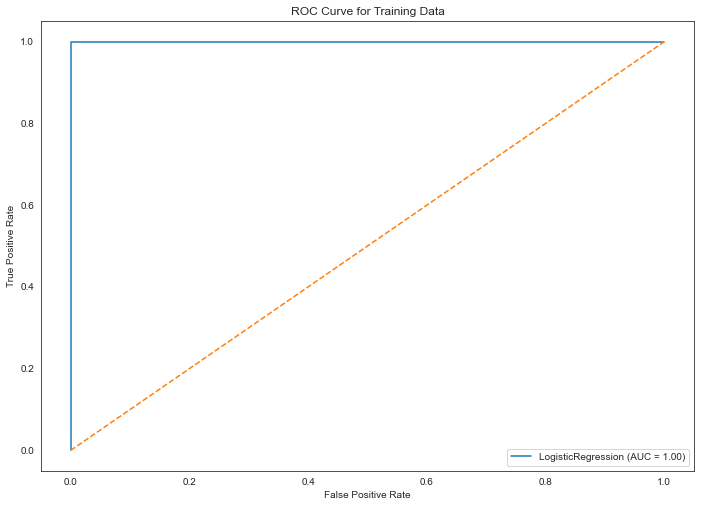

In [28]:
metrics.plot_roc_curve(logreg_clf, X_train_pruned, y_train)
plt.title('ROC Curve for Training Data')
plt.plot([0,1],[0,1],linestyle='--')

In [29]:
# AUC Score
#logreg_clf.decision_function(X_train_pruned)
print('The Area Under Curve Score is: ')
y_scores = logreg_clf.decision_function(X_train_pruned)
roc_auc_score(y_train, y_scores)

The Area Under Curve Score is: 


1.0

The logistic regression paratemeters are as seen above

In [30]:
print('The coefficients of our logistic regression model built from extracted features: \n',logreg_clf.coef_)

The coefficients of our logistic regression model built from extracted features: 
 [[-3.17740225 -1.73026397  3.34619916  4.07776938 -3.01776432]]


In [31]:
# Note
#-------
# reference for this code is mentioned in the citations [18]
# This is a wrapper function written for finding p-values of logistic regression model feautres using the two tailed test 
# This uses the Fisher Information matrix and Inverse Information Matrix to obtain the z_scores for our features in logistic regression model
# These z-scores based on our training data are then used to calculate p values.
# an additional reference used to understand how z_scores are used to find p-values is [19] 

import scipy.stats as stat
denom = (2.0*(1.0+np.cosh(y_scores)))
denom = np.tile(denom,(X_train_pruned.shape[1],1)).T
F_ij = np.dot((X_train_pruned/denom).T,X_train_pruned) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
z_scores = logreg_clf.coef_[0]/sigma_estimates # z-score for each model coefficient
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

In [32]:
print('The p values for the chosen parameters \n',list(pruned_cols),'are \n',p_values)

The p values for the chosen parameters 
 ['3rdQuart1', '3rdQuart3', 'max5', 'mean5', 'max6'] are 
 [0.9925743033798363, 0.993819553734083, 0.9956238685857127, 0.9876708114116411, 0.9953420358508728]


## (d) v. Evaluate the classifier on the Test Set
* The Test data had been prepared previously for testing 

In [33]:
print('Accuracy of the classifier on the test set (broken into same number of time series as the training set): \n',logreg_clf.score(X_test_pruned,y_test)*100,'%')
print('Accuracy of the classifier obtained using cross validation previously: \n',best_grid_score*100,'%')

Accuracy of the classifier on the test set (broken into same number of time series as the training set): 
 100.0 %
Accuracy of the classifier obtained using cross validation previously: 
 98.51648351648352 %


## (d) vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?
Yes, the classes are linearly separable and do cause instability in calculating logistic regression parameters.
(This is also seen when using sm.logit() for logistic regression)

***"A perfect fit or complete separation occurs when there is a linear combination of the predictors that allows perfect distinction between the two groups.  If this happens, the log-likelihood converges to 0, but the parameters do not converge, as there is no unique solution"*** - cited from [13]

A reason for this is since our features are correlated, the above defined situation occurs and is known as a singular matrix issue. The default solver in LogisticRegression in sklearn is a Newton method - it tries to find the inverse Hessian matrix of training data but a dataset as ours cannot be inverted (probably due to high correlation) and we are required to use a quasi-Newton methods such as lbfgs solver which does not require the inverse Hessian Matrix.


## (d) vii. Logistic Regression based on case control sampling

To handle the the problem of class imbalance we can either oversample the minority class with technique such as SMOTE or using case control sampling where we down sample the majority class.
Here we shall go with the under-sampling (downsampling) method since we want to perform case control sampling

In [34]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
sm = NearMiss(version=3)#random_state=0)
#X_train_pruned_sm, y_train_sm = sm.fit_sample(X_train_pruned, y_train.ravel())
#X_train_pruned_sm
#y_train_sm.shape

In [35]:

sm_res_dict = []
for l in range(1,21):
    X = get_complete_data_2(all_files,l)
    # Train
    X_train = X.loc[X['test_train']=='train',:]
    X_train['activity'] = X_train['activity'].apply(lambda x:label_encode(x))
    y_train = X_train['activity']
    X_train = X_train.drop(['activity','test_train'],axis=1)
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())

    # Test
    #X_test = X.loc[X['test_train']=='test',:]
    #X_test['activity'] = X_test['activity'].apply(lambda x:label_encode(x))
    #y_test = X_test['activity']
    #X_test = X_test.drop(['activity','test_train'],axis=1)

    logreg_clf = LogisticRegression(C=sys.maxsize)#(cv=cv, random_state=0,n_jobs=-1).fit(X_train, y_train)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=fixedrstate)
    rfecv = RFECV(logreg_clf,cv=cv,n_jobs = -1)
    rfecv.fit(X_train_sm,y_train_sm)
    #clf = LogisticRegression(cv=cv, random_state=0,n_jobs=-1).fit(X_train, y_train)
    
    #score= clf.score(X_test,y_test)
    sm_res_dict.append({'l':l,'rfe_support':rfecv.support_,'rfe_ranking':rfecv.ranking_,'best_grid_score':rfecv.grid_scores_[rfecv.n_features_-1],'num_features':rfecv.n_features_})
sm_res_dict = pd.DataFrame(sm_res_dict)
sm_res_dict

,l,rfe_support,rfe_ranking,best_grid_score,num_features
0,1,"[False, False, True, True, False, False, False...","[7, 2, 1, 1, 10, 5, 12, 8, 13, 11, 9, 4, 1, 1,...",1.000000,6
1,2,"[True, True, False, True, False, True, False, ...","[1, 1, 6, 1, 4, 1, 5, 1, 1, 1, 3, 2, 1, 1, 1, ...",0.850000,29
2,3,"[False, False, False, False, False, False, Fal...","[41, 26, 40, 2, 45, 33, 42, 3, 25, 29, 46, 38,...",0.875000,5
3,4,"[False, False, False, False, False, False, Fal...","[14, 53, 43, 2, 61, 50, 63, 4, 52, 55, 62, 51,...",0.925000,4
4,5,"[False, False, False, False, False, False, Fal...","[83, 63, 28, 25, 75, 59, 35, 36, 54, 85, 73, 5...",0.916667,6
5,6,"[False, False, False, False, False, False, Fal...","[64, 66, 19, 18, 83, 57, 88, 27, 87, 90, 84, 6...",0.916667,11
6,7,"[True, False, True, True, False, False, False,...","[1, 53, 1, 1, 59, 20, 14, 45, 68, 64, 57, 27, ...",0.866667,57
7,8,"[False, False, False, False, False, False, Fal...","[89, 48, 46, 36, 112, 69, 64, 114, 125, 132, 1...",0.866667,13
8,9,"[False, False, False, False, False, False, Fal...","[139, 85, 47, 49, 136, 95, 135, 84, 127, 146, ...",0.891667,10
9,10,"[False, False, False, False, False, False, Fal...","[133, 103, 58, 44, 140, 107, 98, 91, 97, 151, ...",0.866667,30


In [36]:
best_grid_score = np.max(sm_res_dict['best_grid_score'])
best_l = sm_res_dict.loc[sm_res_dict['best_grid_score']==best_grid_score,:].iloc[0]['l']
num_features = sm_res_dict.loc[sm_res_dict['best_grid_score']==best_grid_score,'num_features'].iloc[0]
selected_features = np.where(sm_res_dict.loc[sm_res_dict['best_grid_score']==best_grid_score,'rfe_support'].iloc[0]==True)

print('The best CV score %s is obtained for l = %s '%(best_grid_score,best_l))
print('Number of parameters chosen:',num_features)

#cv_classifier_accuracy = max(res_dict['best_grid_score'])
#print('The best CV classifier has the accuracy:',cv_classifier_accuracy)

The best CV score 1.0 is obtained for l = 1 
Number of parameters chosen: 6


In [37]:
pruned_cols =X_train.columns[selected_features]
print('The most useful features found: ', pruned_cols)

The most useful features found:  Index(['3rdQuart1', 'max2', 'max5', 'mean5', '3rdQuart5', 'max6'], dtype='object')


In [38]:
# We have the best results for l=1 and p=6 using case_control

X = get_complete_data_2(all_files,best_l)

X_train = X.loc[X['test_train']=='train',:]
X_train['activity'] = X_train['activity'].apply(lambda x:label_encode(x))
y_train = X_train['activity']
X_train = X_train.drop(['activity','test_train'],axis=1)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
X_train_pruned = pd.DataFrame(X_train_sm.loc[:,pruned_cols],columns=pruned_cols)

# Test
X_test = X.loc[X['test_train']=='test',:]
X_test['activity'] = X_test['activity'].apply(lambda x:label_encode(x))
y_test = X_test['activity']
X_test = X_test.drop(['activity','test_train'],axis=1)
X_test_pruned = pd.DataFrame(X_test.loc[:,pruned_cols],columns=pruned_cols)

logreg_clf = LogisticRegression(C=sys.maxsize,n_jobs=-1).fit(X_train_pruned, y_train_sm)

In [39]:
#logreg_clf = LogisticRegression(C=sys.maxsize,n_jobs=-1).fit(X_train_pruned_sm, y_train_sm)
#y_train_pred = logreg_clf.predict(X_train_pruned_sm)
#accuracy_score(y_train_sm,y_train_pred)
#y_pred = logreg_clf.predict(X_test_pruned)
#accuracy_score(y_test,y_pred)

### Performance on Resampled Train Data

In [40]:
# Train Confusion Matrix
y_train_pred = logreg_clf.predict(X_train_pruned)
confusion_matrix(y_train_sm,y_train_pred)

array([[9, 0],
       [0, 9]])

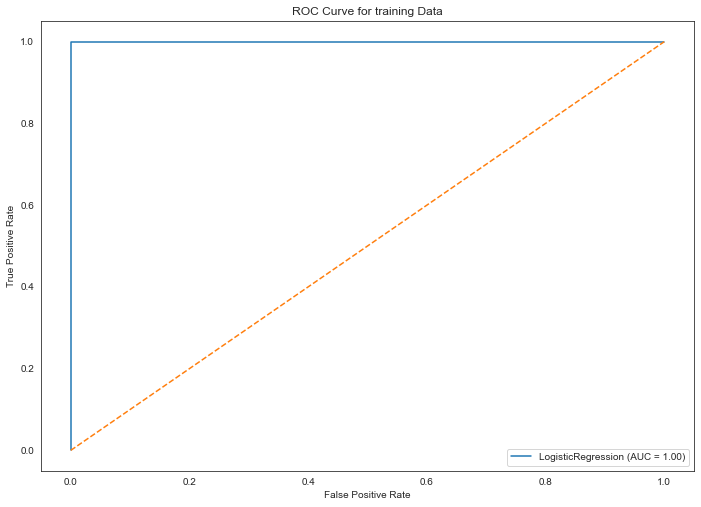

In [41]:
metrics.plot_roc_curve(logreg_clf, X_train_pruned, y_train_sm)
plt.title('ROC Curve for training Data')
plt.plot([0,1],[0,1],linestyle='--')

In [42]:
# AUC Score
print('The Area Under Curve Score is: ')
y_scores = logreg_clf.decision_function(X_train_pruned)
roc_auc_score(y_train_sm, y_scores)

The Area Under Curve Score is: 


1.0

### Performance on Test Data

In [43]:
# Test Confusion Matrix
y_pred = logreg_clf.predict(X_test_pruned)
confusion_matrix(y_test,y_pred)

array([[15,  0],
       [ 0,  4]])

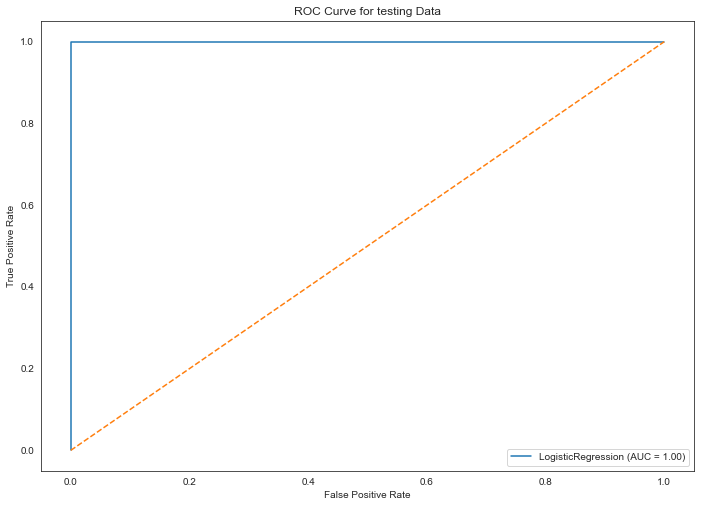

In [44]:
metrics.plot_roc_curve(logreg_clf, X_test_pruned, y_test)
plt.title('ROC Curve for testing Data')
plt.plot([0,1],[0,1],linestyle='--')

In [45]:
# AUC Score
print('The Area Under Curve Score is: ')
y_scores = logreg_clf.decision_function(X_test_pruned)
roc_auc_score(y_test, y_scores)

The Area Under Curve Score is: 


1.0

## (e) i. Binary Classification Using L1-penalized logistic regression

In [46]:
l1_res_dict = []
for l in range(1,21):
    X = get_complete_data_2(all_files,l)
    # Train
    X_train = X.loc[X['test_train']=='train',:]
    X_train['activity'] = X_train['activity'].apply(lambda x:label_encode(x))
    y_train = X_train['activity']
    X_train = X_train.drop(['activity','test_train'],axis=1)

    # Test - Do not need test 
    #X_test = X.loc[X['test_train']=='test',:]
    #X_test['activity'] = X_test['activity'].apply(lambda x:label_encode(x))
    #y_test = X_test['activity']
    #X_test = X_test.drop(['activity','test_train'],axis=1)
    
    #Liblinear method recommends normalization/standardization - so that it executes faster
    normalizer = MinMaxScaler()
    X_train_norm = pd.DataFrame(normalizer.fit_transform(X_train))
    

    logreg_clf = LogisticRegressionCV(n_jobs=-1,cv = 5, class_weight = 'balanced', penalty='l1', solver='liblinear', Cs=100,random_state=fixedrstate) 
    # C = 1/lambda ; paramter supplies the number of values tested from a log scale between 0.0001 and 10000
    # Hence 100 indicates we have 100 candidates for the value of C
    logreg_clf.fit(X_train_norm,y_train)
    
    index_of_best_C = np.where(logreg_clf.Cs_==logreg_clf.C_[0])
    mean_CV_score= np.mean(np.transpose(logreg_clf.scores_[1])[index_of_best_C])
    
    #score= clf.score(X_test,y_test)
    l1_res_dict.append({'l':l,'best_C':logreg_clf.C_[0],'Mean_CV_score':mean_CV_score,'selected_coef':np.where(logreg_clf.coef_!=0)[1]})
l1_res_dict = pd.DataFrame(l1_res_dict)
l1_res_dict

,l,best_C,Mean_CV_score,selected_coef
0,1,6892.612104,0.985714,"[0, 1, 2, 6, 7, 8, 9, 12, 13, 14, 16]"
1,2,0.628029,0.928571,"[1, 12, 33, 34]"
2,3,0.628029,0.971429,"[2, 12, 19, 33, 51, 52]"
3,4,422.924287,0.971429,"[1, 2, 3, 7, 9, 12, 14, 20, 27, 30, 33, 37, 38..."
4,5,2.782559,0.957143,"[2, 12, 14, 30, 38, 51, 64, 69, 87, 88]"
5,6,0.628029,0.957143,"[2, 30, 69, 74, 87, 106]"
6,7,1.321941,0.971429,"[2, 12, 30, 48, 54, 87, 105, 123, 124]"
7,8,1.097499,0.957143,"[2, 12, 30, 48, 74, 105, 141, 142]"
8,9,1.097499,0.942857,"[20, 30, 48, 72, 87, 105, 141]"
9,10,1555.676144,0.942857,"[1, 2, 7, 9, 12, 13, 19, 20, 24, 27, 30, 31, 3..."


In [47]:
best_meancv_score = np.max(l1_res_dict['Mean_CV_score'])
best_l = l1_res_dict.loc[l1_res_dict['Mean_CV_score']==best_meancv_score,:].iloc[0]['l']
selected_features = l1_res_dict.loc[l1_res_dict['Mean_CV_score']==best_meancv_score,'selected_coef'].iloc[0]

print('The best CV score %s is obtained for l = %s '%(best_meancv_score,best_l))
print('Number of parameters chosen:',len(selected_features))
print('The best C(1/lambda) value found with CV :',l1_res_dict.loc[l1_res_dict['Mean_CV_score']==best_meancv_score,'best_C'].iloc[0])

The best CV score 0.9857142857142858 is obtained for l = 1 
Number of parameters chosen: 11
The best C(1/lambda) value found with CV : 6892.61210434971


In [48]:
pruned_cols =list(X_train.columns[selected_features])
#pruned_cols

In [49]:
#retrain based on best C value and selected features
X = get_complete_data_2(all_files,1)

# Train
X_train = X.loc[X['test_train']=='train',:]
X_train['activity'] = X_train['activity'].apply(lambda x:label_encode(x))
y_train = X_train['activity']
X_train = X_train.drop(['activity','test_train'],axis=1)
X_train = X_train.loc[:,pruned_cols]


# Test - Do not need test 
X_test = X.loc[X['test_train']=='test',:]
X_test['activity'] = X_test['activity'].apply(lambda x:label_encode(x))
y_test = X_test['activity']
X_test = X_test.drop(['activity','test_train'],axis=1)
X_test = X_test.loc[:,pruned_cols]

#Liblinear method recommends normalization/standardization - so that it executes faster
normalizer = MinMaxScaler()
X_train_norm = pd.DataFrame(normalizer.fit_transform(X_train),columns = pruned_cols)
X_test_norm = pd.DataFrame(normalizer.fit_transform(X_test),columns = pruned_cols)


logreg_clf = LogisticRegression(C = 6892.61210434971, n_jobs=-1,penalty='l1', solver='liblinear') 
# C = 1/lambda ; paramter supplies the number of values tested from a log scale between 0.0001 and 10000
# Hence 100 indicates we have 100 candidates for the value of C
logreg_clf.fit(X_train_norm,y_train)

/Users/ptk/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=6892.61210434971, n_jobs=-1, penalty='l1',
                   solver='liblinear')

In [50]:
y_pred = logreg_clf.predict(X_test_norm)
confusion_matrix(y_test,y_pred)

array([[15,  0],
       [ 0,  4]])

In [51]:
accuracy_score(y_test,y_pred)

1.0

## (e) ii. L1-penalized v/s RFECV 

**RFECV Model**
* Recursive Feature Selection performed previously gets us the best CV score of **0.9851648351648352**
* Number of parameters chosen : 5
* Test Accuracy = **100%**

**L1-penalized Logistic Regression**
* L1-penalized Logistic Regression obtained a mean CV accuracy of **0.9857142857142858**
* Number of parameters chosen :11
* Test Accuracy = **100%**

Since we did not perform features selection using p-values (we used RFECV) , we shall compare the both these models - they perform the same in terms of test accuracy

From the above we can see that L1-penalized method obtained a slightly better score and it is easier to implement L1 - penalized logistic regression but selects more number of features.

RFECV Model is slower in comparison but has better decision making ability and selects a smaller number of features

RFECV is a wrapper feature selection method and such methods are generally known to be the best feature selection methods but take a long time to run.

Lasso Regression (L1-penalized Logistic regression) comes under embedded feature selection methods as these have a reasonable decision making ability and take a moderate time to run. These are a moderation between filter selection methods and wrapper selection methods. - from [14]

## (f) Multi-class Classification

## (f) i. L1- penalized multinomial regression model

In [52]:
mc_res_dict = []
for l in range(1,21):
    X = get_complete_data_2(all_files,l)
    # Train
    le = preprocessing.LabelEncoder()
    X_train = X.loc[X['test_train']=='train',:]
    le.fit(X_train['activity'])
    y_train = le.transform(X_train['activity'])
    #le.classes_

    X_train = X_train.drop(['activity','test_train'],axis=1)

    # Test - Do not need test for now
    #X_test = X.loc[X['test_train']=='test',:]
    #X_test['activity'] = X_test['activity'].apply(lambda x:label_encode(x))
    #y_test = X_test['activity']
    #X_test = X_test.drop(['activity','test_train'],axis=1)
    
    #saga method recommends normalization/standardization - so that it executes faster
    normalizer = MinMaxScaler()
    X_train_norm = pd.DataFrame(normalizer.fit_transform(X_train))
    

    logreg_clf = LogisticRegressionCV(max_iter=10000,n_jobs=-1,cv = 5, penalty='l1', solver='saga', Cs=100,multi_class='multinomial',random_state=fixedrstate) 
    # C = 1/lambda ; paramter supplies the number of values tested from a log scale between 0.0001 and 10000
    # Hence 100 indicates we have 100 candidates for the value of C between the above scale
    logreg_clf.fit(X_train_norm,y_train)
    
    index_of_best_C = np.where(logreg_clf.Cs_==logreg_clf.C_[0])
    mean_CV_score= np.mean(np.transpose(logreg_clf.scores_[1])[index_of_best_C])
    #print(mean_CV_score)
    
    #score= clf.score(X_test,y_test)
    mc_res_dict.append({'l':l,'best_C':logreg_clf.C_[0],'Mean_CV_score':mean_CV_score})#,'selected_coef':np.where(logreg_clf.coef_!=0)[1]
mc_res_dict = pd.DataFrame(mc_res_dict)
mc_res_dict

,l,best_C,Mean_CV_score
0,1,8.497534,0.913187
1,2,5.857021,0.827473
2,3,291.505306,0.827473
3,4,54.622772,0.827473
4,5,2.310130,0.769231
5,6,0.756463,0.813187
6,7,1.097499,0.812088
7,8,1.097499,0.783516
8,9,2.782559,0.813187
9,10,1.917910,0.797802


In [53]:
best_meancv_score = np.max(mc_res_dict['Mean_CV_score'])
best_l = int(mc_res_dict.loc[mc_res_dict['Mean_CV_score']==best_meancv_score,:].iloc[0]['l'])
#selected_features = mc_res_dict.loc[mc_res_dict['Mean_CV_score']==best_meancv_score,'selected_coef'].iloc[0]
best_C = mc_res_dict.loc[mc_res_dict['Mean_CV_score']==best_meancv_score,'best_C'].iloc[0]

print('The best CV score %s is obtained for l = %s '%(best_meancv_score,best_l))
#print('Number of parameters chosen:',len(selected_features))
print('The best C(1/lambda) value found with CV :',best_C)

The best CV score 0.9131868131868133 is obtained for l = 1 
The best C(1/lambda) value found with CV : 8.497534359086455


In [54]:
#pruned_cols =list(X_train.columns[selected_features])
#pruned_cols

In [55]:
#Retrain using the best l and C
X = get_complete_data_2(all_files,best_l)

# Train
le = preprocessing.LabelEncoder()
X_train = X.loc[X['test_train']=='train',:]
le.fit(X_train['activity'])
y_train = le.transform(X_train['activity'])
X_train = X_train.drop(['activity','test_train'],axis=1)
#X_train = X_train.loc[:,pruned_cols]

# Test
X_test = X.loc[X['test_train']=='test',:]
le.fit(X_test['activity'])
y_test = le.transform(X_test['activity'])
X_test = X_test.drop(['activity','test_train'],axis=1)
#X_test = X_test.loc[:,pruned_cols]

#saga method recommends normalization/standardization - so that it executes faster
normalizer = MinMaxScaler()
X_train_norm = pd.DataFrame(normalizer.fit_transform(X_train),columns = X_train.columns)
X_test_norm = pd.DataFrame(normalizer.fit_transform(X_test),columns = X_test.columns)


logreg_clf = LogisticRegression(max_iter=10000 ,C = best_C,n_jobs=-1, penalty='l1', solver='saga', multi_class='multinomial') 
# C = 1/lambda ; paramter supplies the number of values tested from a log scale between 0.0001 and 10000
# Hence 100 indicates we have 100 candidates for the value of C
logreg_clf.fit(X_train_norm,y_train)

LogisticRegression(C=8.497534359086455, max_iter=10000,
                   multi_class='multinomial', n_jobs=-1, penalty='l1',
                   solver='saga')

In [56]:
# test confusion matrix
y_pred = logreg_clf.predict(X_test_norm)
confusion_matrix(y_test,y_pred)

array([[4, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 3, 0, 0],
       [0, 0, 1, 0, 2, 0],
       [0, 0, 0, 0, 0, 3]])

In [57]:
# test error/accuracy
print('accuracy_score: ',accuracy_score(y_test,y_pred))

#f1 score
print('f1_score: ',f1_score(y_test,y_pred,average='weighted'))

accuracy_score:  0.9473684210526315
f1_score:  0.9458646616541353


### ROC Curve on Test Data

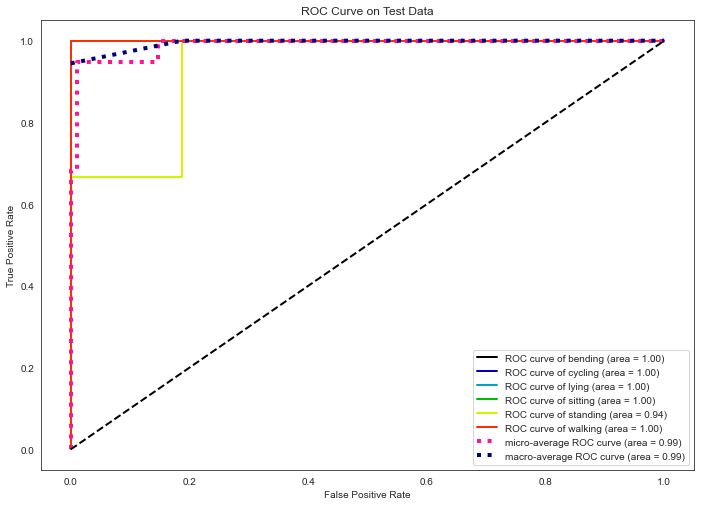

In [58]:
#skplt.metrics.plot_roc_curve(y_train,logreg_clf.predict_proba(X_train_norm))
skplt.metrics.plot_roc(y_test,logreg_clf.predict_proba(X_test_norm),title='ROC Curve on Test Data')
plt_handles,plt_labels = plt.gca().get_legend_handles_labels()
plt_labels[0] = plt_labels[0].replace('class 0','bending')
plt_labels[1] =  plt_labels[1].replace('class 1','cycling')
plt_labels[2] =  plt_labels[2].replace('class 2','lying')
plt_labels[3] =  plt_labels[3].replace('class 3','sitting')
plt_labels[4] =  plt_labels[4].replace('class 4','standing')
plt_labels[5] =  plt_labels[5].replace('class 5','walking')
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.legend(plt_handles,plt_labels)

In [59]:
#skplt.metrics.plot_confusion_matrix(y_test,y_pred)

## (f) ii. Naïve Bayes' Classifier

#### Gaussian Naive Bayes

In [60]:
nbg_res_dict = []
for l in range(1,21):
    X = get_complete_data_2(all_files,l)
    
    # Train
    le = preprocessing.LabelEncoder()
    X_train = X.loc[X['test_train']=='train',:]
    le.fit(X_train['activity'])
    y_train = le.transform(X_train['activity'])

    X_train = X_train.drop(['activity','test_train'],axis=1)

    # Test - Do not need test for now
    #X_test = X.loc[X['test_train']=='test',:]
    #X_test['activity'] = X_test['activity'].apply(lambda x:label_encode(x))
    #y_test = X_test['activity']
    #X_test = X_test.drop(['activity','test_train'],axis=1)

    nbg_clf =  GaussianNB()
    Mean_CV_score = np.mean(cross_val_score(nbg_clf,X_train,y_train,cv=5,n_jobs=-1))
    
    #score= clf.score(X_test,y_test)
    nbg_res_dict.append({'l':l,'Mean_CV_score':Mean_CV_score})
nbg_res_dict = pd.DataFrame(nbg_res_dict)
nbg_res_dict

,l,Mean_CV_score
0,1,0.827473
1,2,0.840659
2,3,0.769231
3,4,0.796703
4,5,0.797802
5,6,0.797802
6,7,0.812088
7,8,0.783516
8,9,0.841758
9,10,0.754945


In [61]:
best_meancv_score = np.max(nbg_res_dict['Mean_CV_score'])
best_l = int(nbg_res_dict.loc[nbg_res_dict['Mean_CV_score']==best_meancv_score,:].iloc[0]['l'])
print('The best CV score %s is obtained for l = %s '%(best_meancv_score,best_l))


The best CV score 0.8417582417582418 is obtained for l = 9 


In [62]:
#Retrain the best model
X = get_complete_data_2(all_files,best_l)
    
# Train
le = preprocessing.LabelEncoder()
X_train = X.loc[X['test_train']=='train',:]
le.fit(X_train['activity'])
y_train = le.transform(X_train['activity'])

X_train = X_train.drop(['activity','test_train'],axis=1)

# Test 
X_test = X.loc[X['test_train']=='test',:]
le.fit(X_test['activity'])
y_test = le.transform(X_test['activity'])
X_test = X_test.drop(['activity','test_train'],axis=1)

nbg_clf =  GaussianNB()
nbg_clf.fit(X_train,y_train)

GaussianNB()

#### ROC AUC and CM

In [63]:
y_pred = nbg_clf.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[4, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 2, 1, 0],
       [0, 0, 0, 1, 2, 0],
       [0, 0, 0, 0, 0, 3]])

In [64]:
# test error/accuracy
print('accuracy_score: ',accuracy_score(y_test,y_pred))

#f1 score
print('f1_score: ',f1_score(y_test,y_pred,average='weighted'))

accuracy_score:  0.8947368421052632
f1_score:  0.8947368421052632


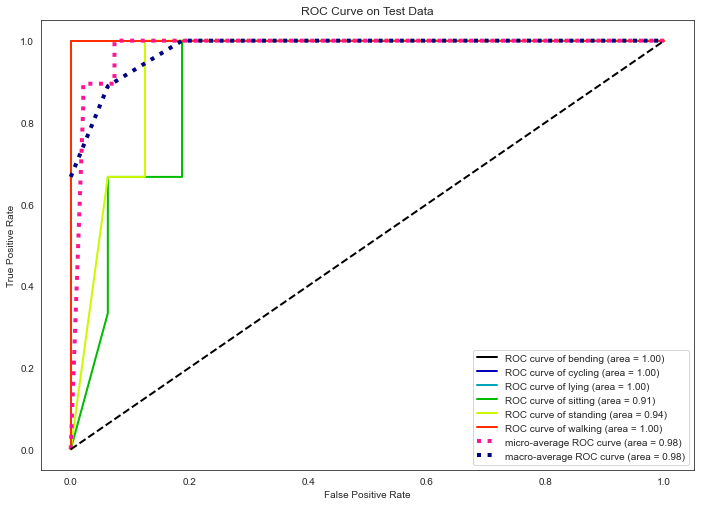

In [65]:
skplt.metrics.plot_roc(y_test,nbg_clf.predict_proba(X_test),title='ROC Curve on Test Data')
plt_handles,plt_labels = plt.gca().get_legend_handles_labels()
plt_labels[0] = plt_labels[0].replace('class 0','bending')
plt_labels[1] =  plt_labels[1].replace('class 1','cycling')
plt_labels[2] =  plt_labels[2].replace('class 2','lying')
plt_labels[3] =  plt_labels[3].replace('class 3','sitting')
plt_labels[4] =  plt_labels[4].replace('class 4','standing')
plt_labels[5] =  plt_labels[5].replace('class 5','walking')
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.legend(plt_handles,plt_labels)

#### Multinomial Naïve Bayes

In [66]:
nbmn_res_dict = []
for l in range(1,21):
    X = get_complete_data_2(all_files,l)
    
    # Train
    le = preprocessing.LabelEncoder()
    X_train = X.loc[X['test_train']=='train',:]
    le.fit(X_train['activity'])
    y_train = le.transform(X_train['activity'])

    X_train = X_train.drop(['activity','test_train'],axis=1)

    # Test - Do not need test for now
    #X_test = X.loc[X['test_train']=='test',:]
    #X_test['activity'] = X_test['activity'].apply(lambda x:label_encode(x))
    #y_test = X_test['activity']
    #X_test = X_test.drop(['activity','test_train'],axis=1)

    nbmn_clf =  MultinomialNB()
    Mean_CV_score = np.mean(cross_val_score(nbmn_clf,X_train,y_train,cv=5,n_jobs=-1))
    
    #score= clf.score(X_test,y_test)
    nbmn_res_dict.append({'l':l,'Mean_CV_score':Mean_CV_score})
nbmn_res_dict = pd.DataFrame(nbmn_res_dict)
nbmn_res_dict

,l,Mean_CV_score
0,1,0.839560
1,2,0.840659
2,3,0.809890
3,4,0.824176
4,5,0.825275
5,6,0.839560
6,7,0.824176
7,8,0.794505
8,9,0.809890
9,10,0.781319


In [67]:
best_meancv_score = np.max(nbmn_res_dict['Mean_CV_score'])
best_l = int(nbmn_res_dict.loc[nbmn_res_dict['Mean_CV_score']==best_meancv_score,:].iloc[0]['l'])
print('The best CV score %s is obtained for l = %s '%(best_meancv_score,int(best_l)))

The best CV score 0.8406593406593407 is obtained for l = 2 


In [68]:
#Retrain the best model
X = get_complete_data_2(all_files,best_l)
    
# Train
le = preprocessing.LabelEncoder()
X_train = X.loc[X['test_train']=='train',:]
le.fit(X_train['activity'])
y_train = le.transform(X_train['activity'])

X_train = X_train.drop(['activity','test_train'],axis=1)

# Test 
X_test = X.loc[X['test_train']=='test',:]
le.fit(X_test['activity'])
y_test = le.transform(X_test['activity'])
X_test = X_test.drop(['activity','test_train'],axis=1)

nbmn_clf =  MultinomialNB()
nbmn_clf.fit(X_train,y_train)

MultinomialNB()

In [69]:
y_pred = nbmn_clf.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[4, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 0, 2, 1, 0, 0],
       [0, 0, 0, 2, 1, 0],
       [0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 3]])

In [70]:
# test error/accuracy
print('accuracy_score: ',accuracy_score(y_test,y_pred))

#f1 score
print('f1-score: ',f1_score(y_test,y_pred,average='weighted'))

accuracy_score:  0.8947368421052632
f1-score:  0.8932330827067669


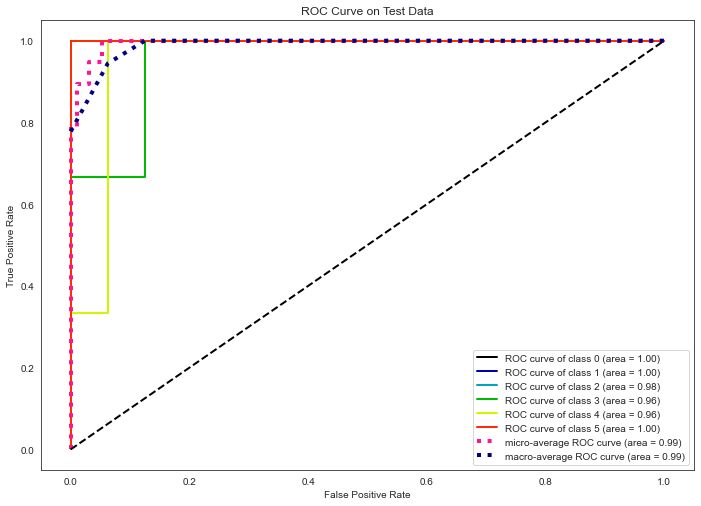

In [71]:
skplt.metrics.plot_roc(y_test,nbmn_clf.predict_proba(X_test),title='ROC Curve on Test Data')
plt_handles,plt_labels = plt.gca().get_legend_handles_labels()
plt_labels[0] = plt_labels[0].replace('class 0','bending')
plt_labels[1] =  plt_labels[1].replace('class 1','cycling')
plt_labels[2] =  plt_labels[2].replace('class 2','lying')
plt_labels[3] =  plt_labels[3].replace('class 3','sitting')
plt_labels[4] =  plt_labels[4].replace('class 4','standing')
plt_labels[5] =  plt_labels[5].replace('class 5','walking')
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.gca().margins(x=0.05,y=0.05)

## (f) iii. Model Comparison

### L1 penalized multinomial regression model
* CV Score : 0.9131868131868133
* Test Accuracy : **0.9473684210526315**
* F1-Score : **0.9458646616541353**

### Gaussian Naive Bayes
* CV Score : 0.8417582417582418
* Test Accuracy : 0.8947368421052632
* F1-Score : 0.8947368421052632

### Multinomial Naive Bayes
* CV Score : 0.8406593406593407
* Test Accuracy : 0.8947368421052632
* F1-Score : 0.8932330827067669


From the above comparison we can see that L1-penalized multinomial regression model performs better both in terms of predicting accuracy and F1-Score. 
This maybe due to the reason that Naïve Bayes classifiers assumes no correlation between the features and since our features are correlated, the performance takes for NB classifiers take a hit.

Note - For F1-score, 'weighted' average for each class was used to account for class imbalance 

## 2. ISLR 3.7.4

(a) The training RSS for cubic model would be lower compared to the linear model as the additional degree would help fit the training data better

(b) For the test data, linear regression model RSS would be lower as compared to the cubic regression as the later is likely to overfit the training data

(c) The added degree of polynomial in the cubic regression would help it fit the training data better and one may expect the cubic regression RSS to be lower given its ability to better to nonlinear relationships. 

(d) In terms of test data, since the true relationship is non-linear - we can now expect to have the test RSS for cubic regressor lower since it can be more flexible.

## 3. ISLR 4.7.3

![Image](ISLR473.JPG)

## 4. ISLR 4.7.7

![Image](ISLR477.JPG)

## Citations & References

* https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory [1]
* https://www.tutorialspoint.com/python/os_walk.htm [2]
* https://stackoverflow.com/questions/25440008/python-pandas-flatten-a-dataframe-to-a-list [3]
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html [4]
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html [5]
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html [6]
* https://pandas.pydata.org/pandas-docs/version/0.22.0/r_interface.html [7]
* https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html [8]
* https://stackoverflow.com/questions/30922213/minimal-example-of-rpy2-regression-using-pandas-data-frame [9]
* https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d [10]
* https://www.kaggle.com/qianchao/smote-with-imbalance-data [11]
* https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul [12]
* https://www.ibm.com/support/pages/logistic-regression-gives-warning-re-unexpected-singularities-hessian-matrix [13]
* https://towardsdatascience.com/feature-selection-why-how-explained-part-2-352d9130c2e1 [14]
* https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB [15]
* https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB [16]
* https://scikit-plot.readthedocs.io/en/stable/metrics.html?highlight=roc#scikitplot.metrics.plot_roc [17]
* https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d [18]
* https://www.sophia.org/tutorials/how-to-find-a-p-value-from-a-z-test-statistic-2 [19]
* https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.NearMiss.html?highlight=nearmiss3#imblearn.under_sampling.NearMiss [20]